In [1]:
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
from numba import njit, prange
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit


warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_using_cv(
        dataset: pd.DataFrame,
        kfold_params: Dict,
        outputs_dir: pathlib.Path,
    ):
    
    kfold = TimeSeriesSplit(**kfold_params)
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'wap', 'wap_lead6', 'index_wap']
    feature_columns = [
        'stock_id',
        'seconds_in_bucket',
        'imbalance_size',
        'imbalance_buy_sell_flag',
        'reference_price',
        'matched_size',
        'far_price',
        'near_price',
        'bid_price',
        'bid_size',
        'ask_price',
        'ask_size',
        'wap',
        'diff_ask_bid_price',
        'sum_ask_bid_price',
        'diff_ask_bid_size',
        'sum_ask_bid_size',
        'diff_far_near_price',
        'sum_far_near_price'
    ]
    time = np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
        'test_mae': [],
    }
    valid_time = time[-92:-46]
    test_time = time[-46:]
    valid_X = dataset.query('date_id in @valid_time')[feature_columns]
    valid_y = dataset.query('date_id in @valid_time')[target_columns]
    test_X = dataset.query('date_id in @test_time')[feature_columns]
    test_y = dataset.query('date_id in @test_time')[target_columns]
    for k, (train_indices, _) in enumerate(kfold.split(time[:-92])):
        #if k+1 != kfold.get_n_splits(): continue
        print(f'fold {k+1}')
        train_time = time[train_indices]
        print(train_time)
        print(valid_time)
        print(train_time.shape, np.min(train_time), np.max(train_time))
        print(valid_time.shape, np.min(valid_time), np.max(valid_time))
        print(test_time.shape, np.min(test_time), np.max(test_time))

        plot_time(time, train_time, valid_time, test_time)
        
        train_X = dataset.query('date_id in @train_time')[feature_columns]
        train_y = dataset.query('date_id in @train_time')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        print(f'test_X.shape : {test_X.shape},  test_y.shape : {test_y.shape}')
        
        objective = Objective(train_X, train_y['wap_lead6'], valid_X, valid_y['wap_lead6'])
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=5)
        best_params = study.best_params
        add_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'seed': 42,
        }
        best_params.update(add_params)

        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')

        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(train_X, train_y['wap_lead6'])
        valid_dataset = lgb.Dataset(valid_X, valid_y['wap_lead6'])
        
        model = lgb.train(
            params=best_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_group_fold{k+1}'),
            num_iteration=model.best_iteration
        )

        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)
        
        test_y[f'regression_wap_lead6_fold{k+1}'] = model.predict(test_X, num_iteration=model.best_iteration)
        
        history['train_mae'].append(
            np.mean(
                abs(train_y['wap_lead6'] - model.predict(train_X, num_iteration=model.best_iteration))
            )
        )
        history['valid_mae'].append(
            np.mean(
                abs(valid_y['wap_lead6'] - model.predict(valid_X, num_iteration=model.best_iteration))
            )
        )
        history['test_mae'].append(
            np.mean(
                abs(test_y['wap_lead6'] - model.predict(test_X, num_iteration=model.best_iteration))
            )
        )
    
    fimps = pd.concat(fimps, axis=1)
    
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    display(fimps)
    
    fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3)
    plt.show()
    
    test_y['regression'] = test_y[[f'regression_wap_lead6_fold{k+1}' for k in range(kfold.get_n_splits())]].mean(axis=1)
    test_y_mae = np.mean(abs(test_y['wap_lead6'] - test_y['regression']))
    print(f'test_y mae: {test_y_mae:.4f}')

    _, ax = plt.subplots()
    _, bins, _ = ax.hist(test_y['wap_lead6'], bins=100, histtype='step', label='truth')
    ax.hist(test_y['regression'], bins=bins, histtype='step', label='regression')
    ax.legend()
    plt.show()
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'test_y rmse': test_y_mae,
            },
            f,
            default_flow_style=False
        )
    return pd.DataFrame.from_dict(history), test_y


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 10),
            #'num_leaves': trial.suggest_int('max_depth', 31, 127),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            #'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            #'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.4, 1.0),
            #'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        train_dataset = lgb.Dataset(self.train_X, self.train_y)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)
        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )

        preds = model.predict(self.valid_X, num_iteration=model.best_iteration)
        rmse = mean_squared_error(self.valid_y, preds)
        return rmse
    

def plot_time(all_time, train_time, valid_time, test_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid', height=0.6, width=[len(train_time), len(valid_time), len(test_time)],
            left=[train_time.min(), valid_time.min(), test_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2, test_time.min()+len(test_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [len(all_time), len(train_time), len(valid_time), len(test_time)]
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), train_time.max(), valid_time.max(), test_time.max(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

In [3]:
def preprocess(df):
    df.eval('diff_ask_bid_price = ask_price - bid_price', inplace=True)
    df.eval('sum_ask_bid_price = ask_price + bid_price', inplace=True)
    df.eval('diff_ask_bid_size = ask_size - bid_size', inplace=True)
    df.eval('sum_ask_bid_size = ask_size + bid_size', inplace=True)
    df.eval('imbalance_buy_sell_flag = imbalance_buy_sell_flag + 1', inplace=True)
    df.eval('diff_far_near_price = far_price - near_price', inplace=True)
    df.eval('sum_far_near_price = far_price + near_price', inplace=True)
    df['wap_lead6'] = df.groupby(['stock_id'])['wap'].shift(-6)
    df.dropna(
        axis=0,
        subset=['wap_lead6'],
        inplace=True,
    )

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,target,time_id,row_id,diff_ask_bid_price,sum_ask_bid_price,diff_ask_bid_size,sum_ask_bid_size,diff_far_near_price,sum_far_near_price,wap_lead6
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,...,-3.029704,0,0_0_0,0.000214,1.999838,-52158.47,69144.53,NaN,NaN,1.000517
1,1,0,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,...,-5.519986,0,0_0_1,0.000764,2.000556,17372.05,23838.13,NaN,NaN,1.000268
2,2,0,0,302879.87,0,0.999561,1819368.03,NaN,NaN,0.999403,...,-8.389950,0,0_0_2,0.000895,1.999701,-18961.00,56951.00,NaN,NaN,0.999981
3,3,0,0,11917682.27,0,1.000171,18389745.62,NaN,NaN,0.999999,...,-4.010200,0,0_0_3,0.000215,2.000213,476707.50,481357.30,NaN,NaN,1.000419
4,4,0,0,447549.96,0,0.999532,17860614.95,NaN,NaN,0.999394,...,-7.349849,0,0_0_4,0.000622,1.999410,-16051.44,16919.64,NaN,NaN,1.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236775,195,480,480,3202296.36,0,1.000551,27733195.21,0.999734,0.999734,1.000551,...,-1.389980,26448,480_480_195,0.000116,2.001218,41110.09,80754.31,0.000000,1.999468,1.000328
5236776,196,480,480,374092.11,0,1.000643,9163117.47,1.000129,1.000129,1.000643,...,1.319647,26448,480_480_196,0.000257,2.001543,-39291.33,178427.15,0.000000,2.000258,1.000819
5236777,197,480,480,1109455.00,0,0.996164,12559273.97,0.995789,0.995883,0.996164,...,-3.259778,26448,480_480_197,0.000374,1.992702,145290.10,230338.10,-0.000094,1.991672,0.995797
5236778,198,480,480,0.00,1,0.999210,94279238.45,0.999210,0.999210,0.999210,...,-2.020001,26448,480_480_198,0.000241,1.998661,59240.07,792296.07,0.000000,1.998420,0.999008


stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894122
near_price                 2856960
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
diff_ask_bid_price               0
sum_ask_bid_price                0
diff_ask_bid_size                0
sum_ask_bid_size                 0
diff_far_near_price        2894122
sum_far_near_price         2894122
wap_lead6                        0
dtype: int64

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'diff_ask_bid_price',
       'sum_ask_bid_price', 'diff_ask_bid_size', 'sum_ask_bid_size',
       'diff_far_near_price', 'sum_far_near_price', 'wap_lead6'],
      dtype='object')


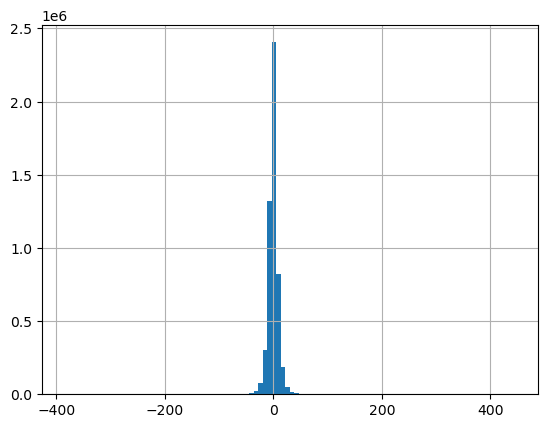

In [4]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path.joinpath('train.csv'))
display(train_df.isna().sum())
train_df = train_df.dropna(subset=['wap', 'target'])
preprocess(train_df)
display(train_df)
display(train_df.isna().sum())
print(train_df.columns)

train_df['target'].hist(bins=100)
plt.show()

In [5]:
train_df['index_wap'] = train_df['wap_lead6'] / train_df['wap'] - train_df['target'] / 10000
train_df['index_wap'] = train_df['index_wap'].round(5)
train_df['mean_wap'] = (
    train_df
    .groupby(['date_id', 'seconds_in_bucket'])['wap']
    .transform('mean')
)
train_df['mean_wap_lead6'] = (
    train_df
    .groupby(['date_id', 'seconds_in_bucket'])['wap_lead6']
    .transform('mean')
)
train_df['mean_wap_lead6_div_mean_wap'] = train_df['mean_wap_lead6'] / train_df['mean_wap']
r = np.corrcoef(train_df["mean_wap_lead6_div_mean_wap"], train_df["index_wap"])[0, 1]
print(f'correlation coefficient: {r:.4f}')

display(train_df[
    ['stock_id', 'date_id', 'bid_size', 'ask_size',
     'wap', 'wap_lead6', 'mean_wap', 'mean_wap_lead6',
     'index_wap', 'mean_wap_lead6_div_mean_wap', 'target']
])

correlation coefficient: 0.6846


,stock_id,date_id,bid_size,ask_size,wap,wap_lead6,mean_wap,mean_wap_lead6,index_wap,mean_wap_lead6_div_mean_wap,target
0,0,0,60651.50,8493.03,1.000000,1.000517,1.00000,1.000756,1.00082,1.000756,-3.029704
1,1,0,3233.04,20605.09,1.000000,1.000268,1.00000,1.000756,1.00082,1.000756,-5.519986
2,2,0,37956.00,18995.00,1.000000,0.999981,1.00000,1.000756,1.00082,1.000756,-8.389950
3,3,0,2324.90,479032.40,1.000000,1.000419,1.00000,1.000756,1.00082,1.000756,-4.010200
4,4,0,16485.54,434.10,1.000000,1.000086,1.00000,1.000756,1.00082,1.000756,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...
5236775,195,480,19822.11,60932.20,1.000579,1.000328,0.99917,0.999098,0.99989,0.999928,-1.389980
5236776,196,480,108859.24,69567.91,1.000800,1.000819,0.99917,0.999098,0.99989,0.999928,1.319647
5236777,197,480,42524.00,187814.10,0.996233,0.995797,0.99917,0.999098,0.99989,0.999928,-3.259778
5236778,198,480,366528.00,425768.07,0.999322,0.999008,0.99917,0.999098,0.99989,0.999928,-2.020001


fold 1
[38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67]
[388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405
 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433]
(30,) 38 67
(46,) 388 433
(46,) 434 479


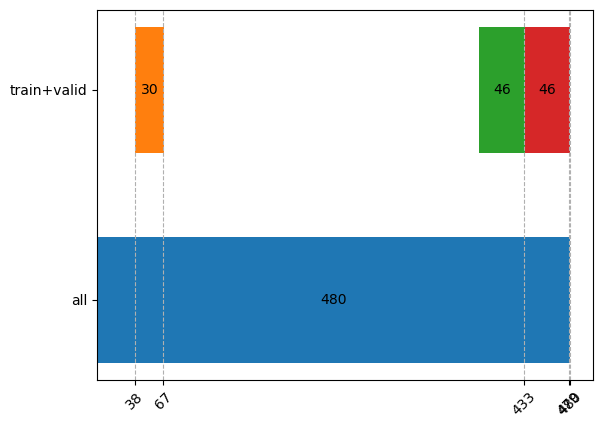

[I 2023-11-09 01:11:41,248] A new study created in memory with name: no-name-7a2474df-52d9-4c38-8e94-fc5d5d604cac


train_X.shape: (320595, 19), train_y.shape: (320595, 7)
valid_X.shape: (505945, 19), valid_y.shape: (505945, 7)
test_X.shape : (505945, 19),  test_y.shape : (505945, 7)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	train's l1: 0.000576175	valid's l1: 0.000719892
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	train's l1: 0.000575708	valid's l1: 0.000719855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[476]	train's l1: 0.00057765	valid's l1: 0.000719917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	train's l1: 0.000576833	valid's l1: 0.000719858
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	train's l1: 0.000576267	valid's l1: 0.000719832
learning_rate: 0.07346740023932911
max_depth: 7
task: train
boosting_type: gbdt

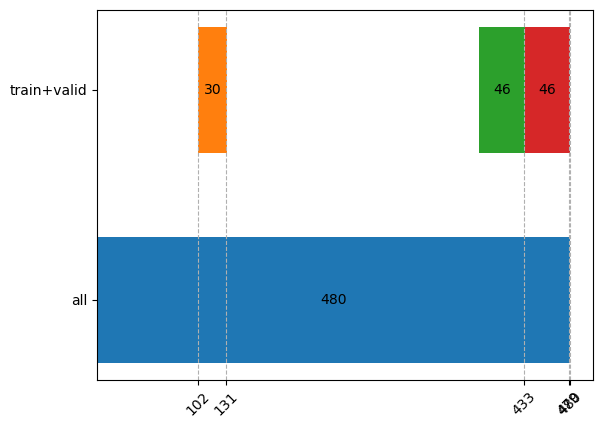

train_X.shape: (325050, 19), train_y.shape: (325050, 7)
valid_X.shape: (505945, 19), valid_y.shape: (505945, 7)
test_X.shape : (505945, 19),  test_y.shape : (505945, 8)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	train's l1: 0.000910311	valid's l1: 0.00072195
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	train's l1: 0.000907751	valid's l1: 0.000722402
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[435]	train's l1: 0.000914055	valid's l1: 0.000722238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[958]	train's l1: 0.000909045	valid's l1: 0.000721799
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	train's l1: 0.000908824	valid's l1: 0.000721926
learning_rate: 0.06051038616257767
max_depth: 8
task: train
boosting_type: gbd

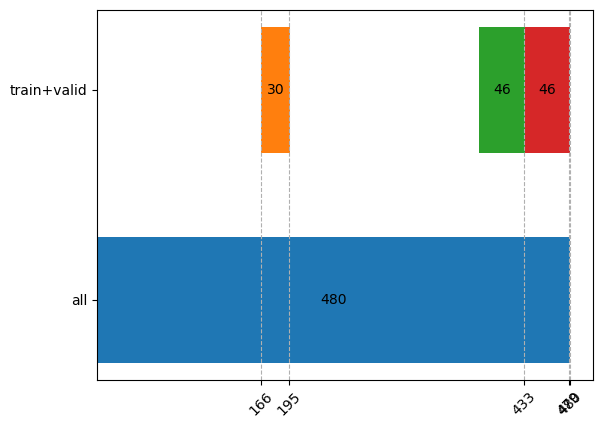

train_X.shape: (326150, 19), train_y.shape: (326150, 7)
valid_X.shape: (505945, 19), valid_y.shape: (505945, 7)
test_X.shape : (505945, 19),  test_y.shape : (505945, 9)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	train's l1: 0.000888463	valid's l1: 0.000718736
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	train's l1: 0.000886689	valid's l1: 0.00071801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[472]	train's l1: 0.000891341	valid's l1: 0.000718382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	train's l1: 0.00089152	valid's l1: 0.000718406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	train's l1: 0.00089064	valid's l1: 0.000719087
learning_rate: 0.07346740023932911
max_depth: 7
task: train
boosting_type: gbdt
o

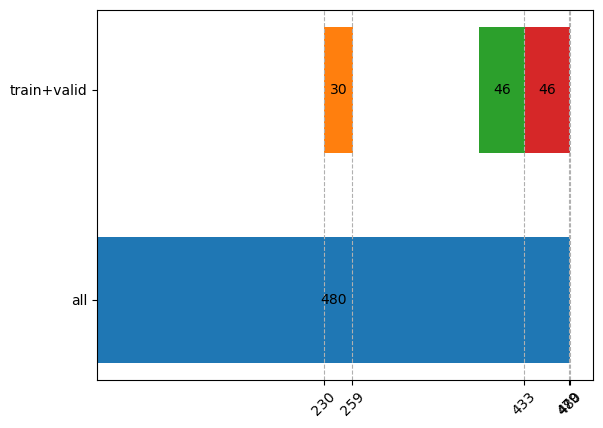

train_X.shape: (328350, 19), train_y.shape: (328350, 7)
valid_X.shape: (505945, 19), valid_y.shape: (505945, 7)
test_X.shape : (505945, 19),  test_y.shape : (505945, 10)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	train's l1: 0.000694439	valid's l1: 0.000720012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	train's l1: 0.000692823	valid's l1: 0.000720166
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	train's l1: 0.000695526	valid's l1: 0.000719409
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[619]	train's l1: 0.000695881	valid's l1: 0.000719872
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	train's l1: 0.000692885	valid's l1: 0.000720081
learning_rate: 0.016445845403801215
max_depth: 4
task: train
boosting_type: g

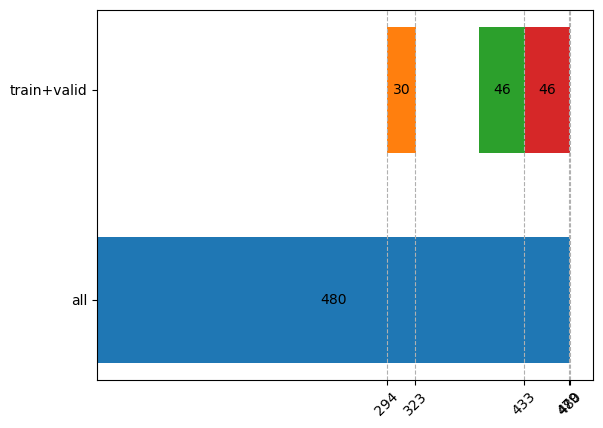

train_X.shape: (329890, 19), train_y.shape: (329890, 7)
valid_X.shape: (505945, 19), valid_y.shape: (505945, 7)
test_X.shape : (505945, 19),  test_y.shape : (505945, 11)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	train's l1: 0.000776878	valid's l1: 0.000741209
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	train's l1: 0.000778262	valid's l1: 0.000741238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[293]	train's l1: 0.000785042	valid's l1: 0.000739257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[797]	train's l1: 0.000776881	valid's l1: 0.000741096
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	train's l1: 0.000776049	valid's l1: 0.000741537
learning_rate: 0.016445845403801215
max_depth: 4
task: train
boosting_type: g

,fold1,fold2,fold3,fold4,fold5,mean_fimps,std_fimps
sum_ask_bid_size,6.205629e+02,6.776407e+02,3.259676e+02,4.886936e+02,0.000000e+00,4.225730e+02,2.722738e+02
sum_far_near_price,5.754339e+02,1.131030e+03,6.621103e+02,5.642060e+02,5.575212e+02,6.980604e+02,2.456934e+02
stock_id,1.615426e+03,1.753495e+03,1.009877e+03,7.453165e+02,1.706899e+02,1.058961e+03,6.484286e+02
ask_size,4.664661e+02,8.092729e+02,3.230729e+03,3.916203e+03,1.978271e+02,1.724100e+03,1.719252e+03
imbalance_buy_sell_flag,1.916293e+03,4.674808e+03,1.752375e+03,4.596571e+02,6.305110e+01,1.773237e+03,1.809022e+03
far_price,2.726078e+03,1.706190e+03,1.276119e+03,2.600745e+03,1.368930e+03,1.935612e+03,6.848233e+02
diff_far_near_price,2.504029e+03,1.042359e+03,6.014158e+02,7.280647e+03,1.157864e+02,2.308847e+03,2.919149e+03
bid_size,2.068797e+03,1.340928e+03,1.073102e+03,1.391250e+02,7.140814e+03,2.352553e+03,2.764399e+03
imbalance_size,3.813060e+03,6.054503e+03,1.839683e+03,6.977909e+02,1.143112e+02,2.503869e+03,2.435879e+03
diff_ask_bid_size,5.946585e+03,4.496361e+03,2.312355e+03,8.943328e+03,2.880834e+03,4.915892e+03,2.663571e+03


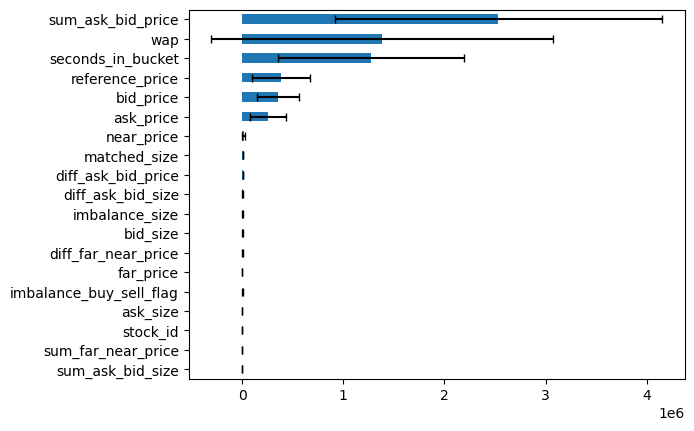

test_y mae: 0.0007


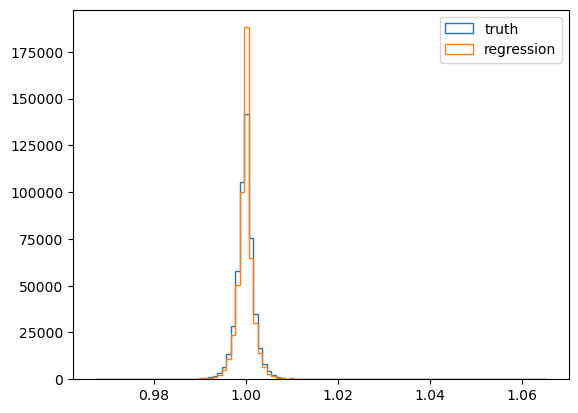

,stock_id,date_id,seconds_in_bucket,target,wap,wap_lead6,index_wap,regression_wap_lead6_fold1,regression_wap_lead6_fold2,regression_wap_lead6_fold3,regression_wap_lead6_fold4,regression_wap_lead6_fold5,regression
4720980,0,434,0,-1.440048,1.000000,1.000011,1.00016,1.000000,0.999953,1.000111,1.000015,0.999710,0.999958
4720981,1,434,0,7.760525,1.000000,1.000931,1.00015,1.000314,1.000091,1.000565,1.000394,1.000034,1.000280
4720982,2,434,0,0.840426,1.000000,1.000239,1.00015,0.999931,0.999914,0.999969,0.999892,0.999503,0.999842
4720983,3,434,0,12.819767,1.000000,1.001437,1.00016,0.999933,0.999873,0.999954,0.999914,0.999555,0.999846
4720984,4,434,0,-13.949871,1.000000,0.998760,1.00015,0.999976,0.999936,1.000023,0.999908,0.999534,0.999875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226975,195,479,540,1.599789,0.999162,0.999786,1.00046,0.999920,0.999960,0.999795,0.999982,0.999488,0.999829
5226976,196,479,540,-8.440018,0.999663,1.000546,1.00173,0.999902,0.999995,0.999790,0.999974,0.999540,0.999840
5226977,197,479,540,5.149841,1.000555,1.000793,0.99972,0.999944,0.999966,0.999815,0.999995,0.999595,0.999863
5226978,198,479,540,-0.249743,0.996908,1.000279,1.00341,0.999915,0.999926,0.999969,0.999966,0.999481,0.999852


In [6]:
kfold_params = {
    'n_splits': 5,
    'max_train_size': 30,
    'test_size': None,
    'gap': 0,
}

history, test_y = train_using_cv(
    kfold_params=kfold_params,
    dataset=train_df,
    outputs_dir=outputs_dir_path, 
)
display(test_y)

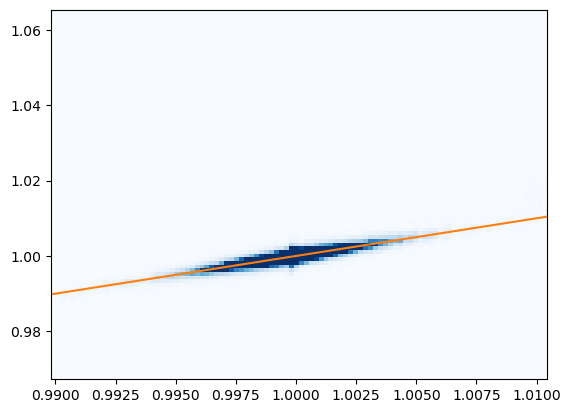

0.8725927062481406


In [7]:
_, ax = plt.subplots()
ax.hist2d(test_y['regression'], test_y['wap_lead6'], bins=100, cmap='Blues', vmax=1e+03)
ax.plot([0, 10], [0, 10], color='tab:orange')
plt.show()

r = np.corrcoef(test_y['regression'], test_y['wap_lead6'])
print(r[0, 1])

In [55]:
test_y['mean_wap'] = (
    test_y
    .groupby(['date_id', 'seconds_in_bucket'])['wap']
    .transform('mean')
)
test_y['mean_regression'] = (
    test_y
    .groupby(['date_id', 'seconds_in_bucket'])['regression']
    .transform('mean')
)
test_y['calculated_target'] = (test_y['regression'] / test_y['wap'] - test_y['mean_regression'] / test_y['mean_wap']) * 10000
r = np.corrcoef(test_y["mean_regression"] / test_y["mean_wap"], test_y["index_wap"])[0, 1]
print(f'correlation coefficient: {r:.4f}')
display(test_y)
display(test_y.isna().sum())
test_y.dropna(inplace=True)

correlation coefficient: 0.3336


,stock_id,date_id,seconds_in_bucket,target,wap,wap_lead6,index_wap,regression_wap_lead6_fold1,regression_wap_lead6_fold2,regression_wap_lead6_fold3,regression_wap_lead6_fold4,regression_wap_lead6_fold5,regression,mean_wap,mean_regression,calculated_target
4720980,0,434,0,-1.440048,1.000000,1.000011,1.00016,1.000000,0.999953,1.000111,1.000015,0.999710,0.999958,1.000000,0.999924,0.340405
4720981,1,434,0,7.760525,1.000000,1.000931,1.00015,1.000314,1.000091,1.000565,1.000394,1.000034,1.000280,1.000000,0.999924,3.559656
4720982,2,434,0,0.840426,1.000000,1.000239,1.00015,0.999931,0.999914,0.999969,0.999892,0.999503,0.999842,1.000000,0.999924,-0.820092
4720983,3,434,0,12.819767,1.000000,1.001437,1.00016,0.999933,0.999873,0.999954,0.999914,0.999555,0.999846,1.000000,0.999924,-0.779657
4720984,4,434,0,-13.949871,1.000000,0.998760,1.00015,0.999976,0.999936,1.000023,0.999908,0.999534,0.999875,1.000000,0.999924,-0.482027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226975,195,479,540,1.599789,0.999162,0.999786,1.00046,0.999920,0.999960,0.999795,0.999982,0.999488,0.999829,0.999385,0.999852,2.003788
5226976,196,479,540,-8.440018,0.999663,1.000546,1.00173,0.999902,0.999995,0.999790,0.999974,0.999540,0.999840,0.999385,0.999852,-2.900999
5226977,197,479,540,5.149841,1.000555,1.000793,0.99972,0.999944,0.999966,0.999815,0.999995,0.999595,0.999863,0.999385,0.999852,-11.589197
5226978,198,479,540,-0.249743,0.996908,1.000279,1.00341,0.999915,0.999926,0.999969,0.999966,0.999481,0.999852,0.999385,0.999852,24.853650


stock_id                      0
date_id                       0
seconds_in_bucket             0
target                        0
wap                           0
wap_lead6                     0
index_wap                     0
regression_wap_lead6_fold1    0
regression_wap_lead6_fold2    0
regression_wap_lead6_fold3    0
regression_wap_lead6_fold4    0
regression_wap_lead6_fold5    0
regression                    0
mean_wap                      0
mean_regression               0
calculated_target             0
dtype: int64

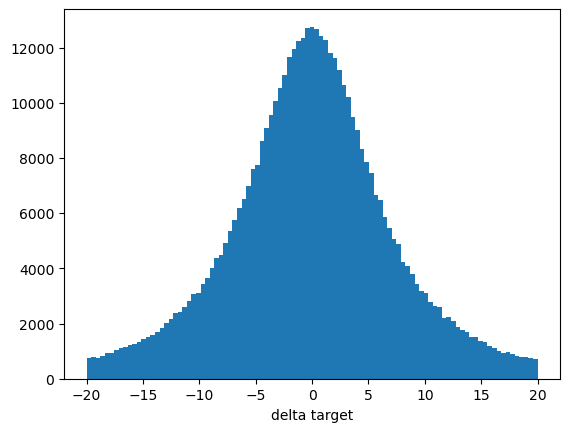

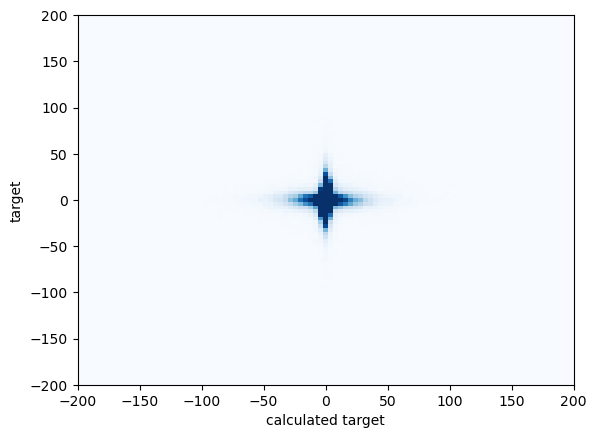

MAE: 7.48394


In [48]:
_, ax = plt.subplots()
ax.hist(test_y['target'] - test_y['calculated_target'], bins=np.linspace(-20, 20, 100))
ax.set_xlabel('delta target')
plt.show()

_, ax = plt.subplots()
ax.hist2d(test_y['calculated_target'], test_y['target'], bins=np.linspace(-200, 200, 100), cmap='Blues', vmin=0, vmax=1e+3)
ax.set_xlabel('calculated target')
ax.set_ylabel('target')
plt.show()

mae = mean_absolute_error(test_y['target'], test_y['calculated_target'])
print(f'MAE: {mae:.5f}')

In [ ]:
history.plot(marker='.', linestyle=':')
plt.show()